# Preparing the Temperature Dataset for Time Series Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import preprocess

# Setting Matplotlib default parameters
plt.rcParams.update( {'font.size':14} )

## 1. Loading the data

The [dataset](https://www.kaggle.com/paulbrabban/daily-minimum-temperatures-in-melbourne) contains the minimum daily temperatures (in Celsius) in Melbourne, Australia recorded over 10 years (1981-1990). 

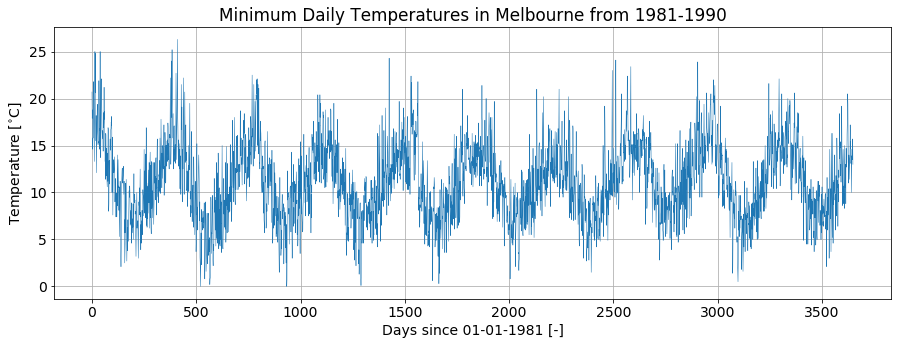

In [2]:
# Loading into a pandas dataframe  with some formatting
temperature_df = pd.read_csv('data/daily-minimum-temperatures-in-me.csv', 
                             names=['Date','Minimum Temperature'], header=0,
                             skipfooter=3, engine='python', parse_dates=['Date'] )

# Some measurements were prefixed with '?', removing them using regex and converting to float
temperature_df['Minimum Temperature'] = temperature_df['Minimum Temperature'].str.replace('[?]', '', regex=True)
temperature_df['Minimum Temperature'] = pd.to_numeric( temperature_df['Minimum Temperature'] )

# Storing the temperature series as numpy array
raw_temperatures = np.array( temperature_df['Minimum Temperature'] )

# Visualizing the trend of minimum temperatures
fig = plt.figure( figsize=(15,5) )
plt.grid(True)
plt.plot( np.arange(len(raw_temperatures)), raw_temperatures, lw=0.5 )
plt.title('Minimum Daily Temperatures in Melbourne from 1981-1990')
plt.xlabel('Days since 01-01-1981 [-]')
plt.ylabel(r'Temperature $[^{\circ}$C]')
plt.show()

## 2. Data pre-processing

According to the paper, the authors have done the following pre-processing steps:
  1. Normalization with $\mu = 0$ and $\sigma = 1$
  2. Denoising with a gaussian filter of size $n = 5$ and standard deviation $\sigma = 2$
  
Here, the raw data is first denoised and then standardized in order to preserve $\mu = 0$ and $\sigma = 1$

Mean = 0.0000, Standard Deviation = 1.0000


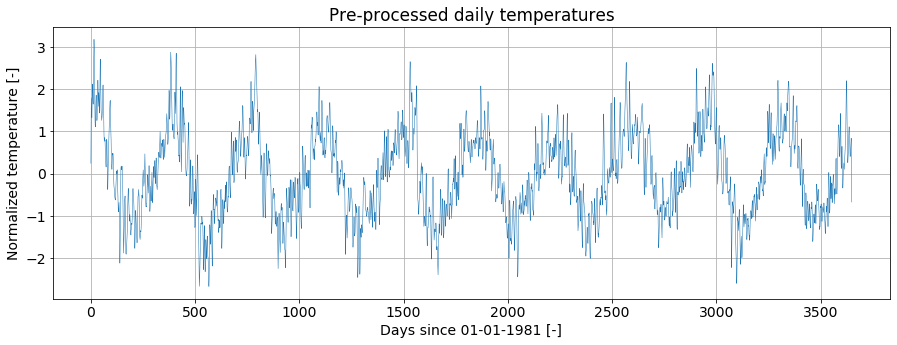

In [3]:
temperatures                       = preprocess.apply_gaussian_filter( raw_temperatures, size=5, sigma=2. )
temperatures, true_mean, true_std  = preprocess.standardize_data( temperatures )
print('Mean = {:.4f}, Standard Deviation = {:.4f}'.format(np.mean(temperatures), np.std(temperatures)))

# Visualizing the trend of preprocessed temperatures
fig = plt.figure( figsize=(15,5) )
plt.grid(True)
plt.plot( np.arange(len(temperatures)), temperatures, lw=0.5 )
plt.title('Pre-processed daily temperatures')
plt.xlabel('Days since 01-01-1981 [-]')
plt.ylabel(r'Normalized temperature [-]')
plt.show()

## 3. Building data samples for Time Series Prediction

For building a Time Series Prediction model based on Supervised Learning, the training, validation and test sets have to be prepared with the following:
  * _**input TS**_  - past temperature measurements  - $\mathbb{R}^{samples\;\times\;timesteps\;\times\;features}$
  * _**target TS**_ - future temperature measurements - $\mathbb{R}^{samples\;\times\;timesteps}$
  
According to the paper, the **input TS** has a window size $T = 0\;mod\;4$ since the proposed method uses downsampling to $1/2$ and $1/4$ of the initial TS window size. 

The **target TS** has the following prediction horizons:
  * One-Step TS Prediction : horizon = $1$
  * Multi-step TS Prediction : horizon $\in \{3,5,7\}$
  
### 3.1. Windowed Dataset generation

In [13]:
# Parameters to create the TS dataset
window_size = 20
prediction_horizon = 7

# Generate TS dataset for TS prediction
x, y = preprocess.generate_TS_dataset( temperatures, window_size, prediction_horizon )
x, y = preprocess.shuffle_data( x,y )

# Reshape x into 3D shape [samples, timesteps, features]
x = x[:,:,np.newaxis]

print('Total number of windowed samples : ', x.shape[0])
print('Shape of inputs TS               : ', x.shape)
print('Shape of targets TS              : ', y.shape)

Total number of windowed samples :  3624
Shape of inputs TS               :  (3624, 20, 1)
Shape of targets TS              :  (3624, 7)


### 3.2. Visualize a sample from the dataset

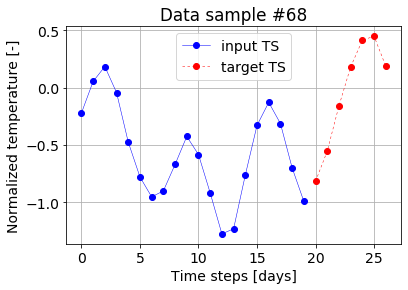

In [14]:
index = np.random.randint( x.shape[0] )
x_ = x[index,...]
y_ = y[index,...]
fig = plt.figure()
plt.grid(True)
plt.plot( np.arange(window_size), x_, color='b', ls='-', marker='o', lw=0.5, label='input TS')
plt.plot( np.arange(window_size,window_size+prediction_horizon), y_, 
             marker='o', color='r', ls=(0,(5,5)), lw=0.5, label='target TS')
plt.xlabel('Time steps [days]')
plt.ylabel('Normalized temperature [-]')
plt.legend()
plt.title('Data sample #{}'.format(index))
plt.show()

### 3.3. Save the dataset as a HDF5 file

In [15]:
if False:
    save_path = 'data/temperature_' + str(prediction_horizon) + '-step.hdf5'
    preprocess.save_hdf5( save_path, x, y, true_mean=None, true_std=None )

Datasets have been saved as hdf5 file
